In this notebook, we'll demonstrate the design and training of the two-stage proofreading mechanism for robust self-assembly. In particular, we will focus on the 2D patchy particle system with the goal of growing a perfect 2D ladder, as described in the main text.

In the first stage (state change), we are going to learn an optimal local update rule which is parameterized by a graph neural network to reinforce the correct bonds.
In the second stage, we are going to add a reverse pathway that is similar to Hopfield's kinetic proofreading theory. Specifically, we will randomly decrease the bond strength of particles that have gone through state change in the first stage. This two-stage proofreading mechanism is demonstrated to substantially increase the yield of the desired structures over a much broader temperature range.


# Import

First we need to import relevant packages (with fixed versions for future reference)

## Install packages

In [ ]:
!pip install --upgrade pip==23.1.2
!pip install --upgrade jax==0.4.13 jaxlib==0.4.13+cuda11.cudnn86 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install flax==0.7.2
!pip install jax-tqdm
!pip install chex==0.1.8
!pip install e3nn-jax==0.18.0
!pip install jax-md==0.2.3
!pip install -U tensorflow==2.12.0
!pip install equinox==0.9.2
!pip install distrax==0.1.3
!pip install dm-haiku==0.0.10
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
gpu


## Import modules

Here we import relevant modules and functions with some modifications adapted for our purpose.

In [ ]:
import jax.numpy as jnp
import numpy as onp
import jax
import jax_md
import functools
from jax import random
from jax import jit
from jax import lax
from jax import vmap
from jax.example_libraries import optimizers
from jax.config import config
config.update("jax_enable_x64", True)
import time
import pickle
config.update("jax_debug_nans", True)
from jax_md import space, energy, minimize, quantity, simulate, rigid_body
import os
import sys
from os.path import exists
from pathlib import Path
import distrax
import equinox as eqx
import haiku as hk

# Copyright 2021 DeepMind Technologies Limited. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""Bernoulli distribution."""

from typing import Optional, Tuple, Union

import chex
from distrax._src.distributions import distribution
from distrax._src.utils import conversion
from distrax._src.utils import math
from tensorflow_probability.substrates import jax as tfp

tfd = tfp.distributions

Array = chex.Array
Numeric = chex.Numeric
PRNGKey = chex.PRNGKey


def multiply_no_nan(x: Array, y: Array) -> Array:
  """Equivalent of TF `multiply_no_nan`.

  Computes the element-wise product of `x` and `y` and return 0 if `y` is zero,
  even if `x` is NaN or infinite.

  Args:
    x: First input.
    y: Second input.

  Returns:
    The product of `x` and `y`.

  Raises:
    ValueError if the shapes of `x` and `y` do not match.
  """
  dtype = jnp.result_type(x, y)
  return jnp.where(y == 0, jnp.zeros((), dtype=dtype), jnp.nan_to_num(x) * y)

def as_float_array(x):
  """Converts input to an array with floating-point dtype.

  If the input is already an array with floating-point dtype, it is returned
  unchanged.

  Args:
    x: input to convert.

  Returns:
    An array with floating-point dtype.
  """
  # if not isinstance(x, Array):
  #   x = jnp.asarray(x)
  if jnp.issubdtype(x.dtype, jnp.floating):
    return x
  elif jnp.issubdtype(x.dtype, jnp.integer):
    return x.astype(jnp.float_)
  else:
    raise ValueError(
        f"Expected either floating or integer dtype, got {x.dtype}.")


class Bernoulli(distribution.Distribution):
  """Bernoulli distribution.

  Bernoulli distribution with parameter `probs`, the probability of outcome `1`.
  """

  equiv_tfp_cls = tfd.Bernoulli

  def __init__(self,
               logits: Optional[Numeric] = None,
               probs: Optional[Numeric] = None,
               dtype: jnp.dtype = int):
    """Initializes a Bernoulli distribution.

    Args:
      logits: Logit transform of the probability of a `1` event (`0` otherwise),
        i.e. `probs = sigmoid(logits)`. Only one of `logits` or `probs` can be
        specified.
      probs: Probability of a `1` event (`0` otherwise). Only one of `logits` or
        `probs` can be specified.
      dtype: The type of event samples.
    """
    super().__init__()
    # Validate arguments.
    chex.assert_exactly_one_is_none(probs, logits)
    if not (jnp.issubdtype(dtype, bool) or
            jnp.issubdtype(dtype, jnp.integer) or
            jnp.issubdtype(dtype, jnp.floating)):
      raise ValueError(
          f'The dtype of `{self.name}` must be boolean, integer or '
          f'floating-point, instead got `{dtype}`.')
    # Parameters of the distribution.
    self._probs = None if probs is None else as_float_array(probs)
    self._logits = None if logits is None else as_float_array(logits)
    self._dtype = dtype

  @property
  def event_shape(self) -> Tuple[int, ...]:
    """See `Distribution.event_shape`."""
    return ()

  @property
  def batch_shape(self) -> Tuple[int, ...]:
    """See `Distribution.batch_shape`."""
    if self._logits is not None:
      return self._logits.shape
    return self._probs.shape

  @property
  def logits(self) -> Array:
    """The logits of a `1` event."""
    if self._logits is not None:
      return self._logits
    return jnp.log(self._probs) - jnp.log(1 - self._probs)

  @property
  def probs(self) -> Array:
    """The probabilities of a `1` event.."""
    if self._probs is not None:
      return self._probs
    return jax.nn.sigmoid(self._logits)

  def _log_probs_parameter(self) -> Tuple[Array, Array]:
    if self._logits is None:
      return (jnp.log1p(-1. * self._probs),
              jnp.log(self._probs))
    return (-jax.nn.softplus(self._logits),
            -jax.nn.softplus(-1. * self._logits))

  def _sample_n(self, key: PRNGKey, n: int) -> Array:
    """See `Distribution._sample_n`."""
    probs = self.probs
    new_shape = (n,) + probs.shape
    uniform = jax.random.uniform(
        key=key, shape=new_shape, dtype=probs.dtype, minval=0., maxval=1.)
    return jnp.less(uniform, probs).astype(self._dtype)

  def log_prob(self, value: Array) -> Array:
    """See `Distribution.log_prob`."""
    log_probs0, log_probs1 = self._log_probs_parameter()
    return (multiply_no_nan(log_probs0, 1 - value) +
            multiply_no_nan(log_probs1, value))

  def prob(self, value: Array) -> Array:
    """See `Distribution.prob`."""
    probs1 = self.probs
    probs0 = 1 - probs1
    return (multiply_no_nan(probs0, 1 - value) +
            multiply_no_nan(probs1, value))

  def cdf(self, value: Array) -> Array:
    """See `Distribution.cdf`."""
    # For value < 0 the output should be zero because support = {0, 1}.
    return jnp.where(value < 0,
                     jnp.array(0., dtype=self.probs.dtype),
                     jnp.where(value >= 1,
                               jnp.array(1.0, dtype=self.probs.dtype),
                               1 - self.probs))

  def log_cdf(self, value: Array) -> Array:
    """See `Distribution.log_cdf`."""
    return jnp.log(self.cdf(value))

  def entropy(self) -> Array:
    """See `Distribution.entropy`."""
    (probs0, probs1,
     log_probs0, log_probs1) = _probs_and_log_probs(self)
    return -1. * (
        multiply_no_nan(log_probs0, probs0) +
        multiply_no_nan(log_probs1, probs1))

  def mean(self) -> Array:
    """See `Distribution.mean`."""
    return self.probs

  def variance(self) -> Array:
    """See `Distribution.variance`."""
    return (1 - self.probs) * self.probs

  def mode(self) -> Array:
    """See `Distribution.probs`."""
    return (self.probs > 0.5).astype(self._dtype)

  def median(self) -> Array:
    """See `Distribution.median`."""
    return self.mean()

  def __getitem__(self, index) -> 'Bernoulli':
    """See `Distribution.__getitem__`."""
    index = distribution.to_batch_shape_index(self.batch_shape, index)
    if self._logits is not None:
      return Bernoulli(logits=self.logits[index], dtype=self._dtype)
    return Bernoulli(probs=self.probs[index], dtype=self._dtype)


def _probs_and_log_probs(
    dist: Union[Bernoulli, tfd.Bernoulli]
    ) -> Tuple[Array, Array, Array, Array]:
  """Calculates both `probs` and `log_probs`."""
  # pylint: disable=protected-access
  if dist._logits is None:
    probs0 = 1 - dist._probs
    probs1 = dist._probs
    log_probs0 = jnp.log1p(-1. * dist._probs)
    log_probs1 = jnp.log(dist._probs)
  else:
    probs0 = jax.nn.sigmoid(-1. * dist._logits)
    probs1 = jax.nn.sigmoid(dist._logits)
    log_probs0 = -jax.nn.softplus(dist._logits)
    log_probs1 = -jax.nn.softplus(-1. * dist._logits)
  return probs0, probs1, log_probs0, log_probs1


def _kl_divergence_bernoulli_bernoulli(
    dist1: Union[Bernoulli, tfd.Bernoulli],
    dist2: Union[Bernoulli, tfd.Bernoulli],
    *unused_args, **unused_kwargs,
    ) -> Array:
  """KL divergence `KL(dist1 || dist2)` between two Bernoulli distributions.

  Args:
    dist1: instance of a Bernoulli distribution.
    dist2: instance of a Bernoulli distribution.

  Returns:
    Batchwise `KL(dist1 || dist2)`.
  """
  one_minus_p1, p1, log_one_minus_p1, log_p1 = _probs_and_log_probs(dist1)
  _, _, log_one_minus_p2, log_p2 = _probs_and_log_probs(dist2)
  # KL[a || b] = Pa * Log[Pa / Pb] + (1 - Pa) * Log[(1 - Pa) / (1 - Pb)]
  # Multiply each factor individually to avoid Inf - Inf
  return (
      multiply_no_nan(log_p1, p1) -
      multiply_no_nan(log_p2, p1) +
      multiply_no_nan(log_one_minus_p1, one_minus_p1) -
      multiply_no_nan(log_one_minus_p2, one_minus_p1)
  )


# Register the KL functions with TFP.
tfd.RegisterKL(Bernoulli, Bernoulli)(
    _kl_divergence_bernoulli_bernoulli)
tfd.RegisterKL(Bernoulli, Bernoulli.equiv_tfp_cls)(
    _kl_divergence_bernoulli_bernoulli)
tfd.RegisterKL(Bernoulli.equiv_tfp_cls, Bernoulli)(
    _kl_divergence_bernoulli_bernoulli)

/usr/local/lib/python3.10/dist-packages/jaxtyping/__init__.py:221: UserWarning: jaxtyping version >=0.2.23 should be used with Equinox version >=0.11.1
  warnings.warn(


<function __main__._kl_divergence_bernoulli_bernoulli(dist1: Union[__main__.Bernoulli, tensorflow_probability.substrates.jax.distributions.bernoulli.Bernoulli], dist2: Union[__main__.Bernoulli, tensorflow_probability.substrates.jax.distributions.bernoulli.Bernoulli], *unused_args, **unused_kwargs) -> Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number]>

Forward-mode AD, return both the gradients and the current values.

In [ ]:
"""Utilities for computing gradients."""

from typing import Callable

def _first_arg_partial(f, *args, **kwargs):
  def f_(x):
    return f(x, *args, **kwargs)
  return f_

def _split_and_pack_like(j, x):
  leaves, structure = jax.tree_util.tree_flatten(x)
  sizes = [leaf.size for leaf in leaves]
  split = jnp.split(j, onp.cumsum(sizes), axis=-1)
  reshaped = [s.reshape(s.shape[:-1] + y.shape) for s, y in zip(split, leaves)]
  return jax.tree_util.tree_unflatten(structure, reshaped)

def _tangents_like(x):
  eye = onp.eye(sum([leaf.size for leaf in jax.tree_util.tree_leaves(x)]))
  return _split_and_pack_like(eye, x)

def value_and_jacfwd(f: Callable) -> Callable:
  """Returns a function that computes the Jacobian for the first argument,
  along with the value of the function."""
  def val_and_jac(*args, **kwargs):
    partial_f = _first_arg_partial(f, *args[1:], **kwargs)
    tangents = _tangents_like(args[0])
    jvp = functools.partial(jax.jvp, partial_f, (args[0],), has_aux = True)
    y, jac, y2 = jax.vmap(jvp, out_axes=-1)((tangents,))
    y = jax.tree_map(lambda x: x[..., 0], y)
    y2 = jax.tree_map(lambda x: x[..., 0], y2)
    jac = jax.tree_map(lambda j: _split_and_pack_like(j, args[0]), jac)
    return y, y2, jac
  return val_and_jac

Modify the source code of JAXMD to enable the dynamical update of species.

In [ ]:
from typing import Tuple, Optional, Callable

from jax_md import util
from jax import tree_map

Array = util.Array

RigidBody = rigid_body.RigidBody
RigidPointUnion = rigid_body.RigidPointUnion
transform = rigid_body.transform

def union_to_points(body: RigidBody,
                    shape: RigidPointUnion,
                    shape_species: Optional[onp.ndarray]=None,
                    **kwargs,
                    ) -> Tuple[Array, Optional[Array]]:
  """Transforms points in a RigidPointUnion to world space."""
  if shape_species is None:
    position = vmap(transform, (0, None))(body, shape)
    point_species = shape.point_species
    body_id = jnp.arange(len(body.center))
    body_id = jnp.broadcast_to(body_id[:, None], position.shape[:-1])
    body_id = jnp.reshape(body_id, (-1,))
    if point_species is not None:
      point_species = shape.point_species[None, :]
      point_species = jnp.broadcast_to(point_species, position.shape[:-1])
      point_species = jnp.reshape(point_species, (-1,))
    position = jnp.reshape(position, (-1, position.shape[-1]))
    return position, point_species, body_id
  elif isinstance(shape_species, onp.ndarray):
    shape_species_types = onp.unique(shape_species)
    shape = tree_map(lambda x: onp.array(x), shape)

    point_position = []
    point_species = []
    body_ids = []

    body_id = jnp.arange(len(body.center))

    for s in shape_species_types:
      cur_shape = shape[s]
      pos = vmap(transform, (0, None))(body[shape_species == s], cur_shape)

      this_body_id = body_id[shape_species == s]
      this_body_id = jnp.broadcast_to(this_body_id[:, None], pos.shape[:-1])
      body_ids += [jnp.reshape(this_body_id, (-1,))]

      ps = cur_shape.point_species
      if ps is not None:
        ps = cur_shape.point_species[None, :]
        ps = jnp.broadcast_to(ps, pos.shape[:-1])
        point_species += [jnp.reshape(ps, (-1,))]

      pos = jnp.reshape(pos, (-1, pos.shape[-1]))
      point_position += [pos]
    point_position = jnp.concatenate(point_position)
    point_species = jnp.concatenate(point_species) if point_species else None
    body_ids = jnp.concatenate(body_ids)
    return point_position, point_species, body_ids
  else:
    raise NotImplementedError('Shape species must either be None or of type '
                              'onp.ndarray since it must be specified ahead '
                              f'of compilation. Found {type(shape_species)}.')

# Energy Functions
def point_energy(energy_fn: Callable[..., Array],
                 shape: RigidPointUnion,
                 shape_species: Optional[onp.ndarray]=None
                 ) -> Callable[..., Array]:
  """Produces a RigidBody energy given a pointwise energy and a point union.
  This function takes takes a pointwise energy function that computes the
  energy of a set of particle positions along with a RigidPointUnion
  (optionally with shape species information) and produces a new energy
  function that computes the energy of a collection of rigid bodies.
  Args:
    energy_fn: An energy function that takes point positions and produces a
      scalar energy function.
    shape: A RigidPointUnion shape that contains one or more shapes defined as
      a union of point masses.
    shape_species: An optional array specifying the composition of the system
      in terms of shapes.
  Returns:
    An energy function that takes a `RigidBody` and produces a scalar energy
    energy.
  """
  def wrapped_energy_fn(body, **kwargs):
    pos, point_species, body_id = union_to_points(body, shape, shape_species)
    if point_species is None:
      return energy_fn(pos, **kwargs)
    return energy_fn(pos, shape = shape, species=point_species, body_id=body_id, **kwargs)
  return wrapped_energy_fn

## Plot Lib

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='white')
sns.set(font_scale=1.6)

def format_plot(x, y, fontsize = 20):
  plt.xlabel(x, fontsize=fontsize)
  plt.ylabel(y, fontsize=fontsize)

def finalize_plot(shape=(1, 1)):
  plt.gcf().set_size_inches(
    shape[0] * 1.5 * plt.gcf().get_size_inches()[1],
    shape[1] * 1.5 * plt.gcf().get_size_inches()[1])
  plt.tight_layout()

Function to plot the patchy particle system.

In [ ]:
'''
Helper function to plot the central particle and patches of one species
'''
def body_to_plot0(body, thetas, box_size, color = 'navy', markersize = 500, markerratio = 0.2):
  shape = thetas_to_shape(thetas, radius=center_particle_rad)
  body_pos = vmap(rigid_body.transform, (0, None))(body, shape)
  bodypos = body_pos.reshape(-1, 2)
  species_list = jnp.array(list(jnp.arange(num_patch+1)) * len(body.center))

  inds_at_id = lambda id: jnp.squeeze(jnp.argwhere(species_list==id))
  center_particles = bodypos[inds_at_id(0)]
  list_of_patch_particles = []
  for i in range(1, len(thetas)+1):
    list_of_patch_particles += [bodypos[inds_at_id(i)]]

  colors = ['crimson', 'dodgerblue', 'green']

  if len(center_particles.shape) == 1:
    plt.scatter(center_particles[0], center_particles[1], s=markersize, color=color, alpha=0.4)
    for ind, p in enumerate(list_of_patch_particles):
      plt.scatter(p[0], p[1], s=markersize*markerratio, color = colors[onp.remainder(ind,3)], alpha = 0.4)
  else:
    plt.scatter(center_particles[:, 0], center_particles[:, 1], s=markersize, color=color, alpha=0.4)
    for ind, p in enumerate(list_of_patch_particles):
      plt.scatter(p[:, 0], p[:, 1], s=markersize*markerratio, color = colors[onp.remainder(ind,3)], alpha = 0.4)

'''
Plot the configurations of all particles with color correponsding to its species
Species 1: yellow
Species 2: purple
Species 3: orange
'''
def body_to_plot3(body, thetas, box_size, species, color = 'navy', markersize = 500, markerratio = 0.2):
  ind1 = jnp.argwhere(species == 1).reshape(1,-1)[0]
  ind2 = jnp.argwhere(species == 2).reshape(1,-1)[0]
  ind3 = jnp.argwhere(species == 3).reshape(1,-1)[0]

  body_to_plot0(rigid_body.RigidBody(body.center[ind2],body.orientation[ind2]), thetas, box_size, color = color, markersize = markersize, markerratio = markerratio)
  body_to_plot0(rigid_body.RigidBody(body.center[ind3],body.orientation[ind3]), thetas, box_size, color = 'darkorange', markersize = markersize, markerratio = markerratio)
  body_to_plot0(rigid_body.RigidBody(body.center[ind1],body.orientation[ind1]), thetas, box_size, color = 'y', markersize = markersize, markerratio = markerratio)

  shape0 = thetas_to_shape_seed(jnp.pi*0.5, radius=center_particle_rad)
  seed_pos = rigid_body.transform(rigid_body.RigidBody(body.center[0,:], body.orientation[0]), shape0)
  plt.scatter(seed_pos[:2, 0], seed_pos[:2, 1], s=markersize, color=color, alpha=0.4)
  plt.scatter(seed_pos[2, 0], seed_pos[2, 1], s=markersize*markerratio, color='dodgerblue', alpha=0.4)
  plt.scatter(seed_pos[3, 0], seed_pos[3, 1], s=markersize*markerratio, color='crimson', alpha=0.4)
  plt.scatter(body.center[0, 0], body.center[0, 1], s=markersize*markerratio, color='green', alpha=0.4)


  plt.axis('equal')

  plt.xlim([0, box_size])
  plt.ylim([0, box_size])

  fig = plt.gcf()
  fig.set_size_inches(5.0, 5.0)


Functions to plot energy and loss evolution

In [ ]:
def plot_energy(energies, num_steps, label = None, upper = 300, lower = -300, alpha = 0.4):
  mean_energy = jnp.mean(energies, axis = 0)
  std_energy = jnp.std(energies, axis = 0)

  plt.plot(jnp.arange(num_steps), mean_energy, linewidth=1, label = label)
  plt.fill_between(jnp.arange(num_steps), mean_energy + std_energy, mean_energy - std_energy, alpha=alpha)

  # plt.xlim([1000, 40000])
  plt.ylim([lower, upper])

  format_plot('Time step', '$\\langle Energy\\rangle$')

def plot_loss(energies, num_steps, label = None, upper = 300, lower = -300, alpha = 0.4):
  mean_energy = jnp.mean(energies, axis = 0)
  std_energy = jnp.std(energies, axis = 0)

  plt.plot(jnp.arange(num_steps), mean_energy, linewidth=1, label = label)
  plt.fill_between(jnp.arange(num_steps), mean_energy + std_energy, mean_energy - std_energy, alpha=alpha)

  # plt.xlim([1000, 40000])
  plt.ylim([lower, upper])

  format_plot('Time step', '$\\langle Loss\\rangle$')

# Set up the system

In this section, we will set up the system for simulation, which includes:
- Instantiate the individual patchy particle as rigid body in JAX-MD
- Define the simulation parameters

In [ ]:
N = 20 # number of particles = 1(seed) + 19(normal particles). When evaluating the yield, N is set to be 9 (i.e. 1(seed) + 8(normal particles)).
num_density = 0.2 # volume fraction
dim = 2 # dimension
num_patch = 3 # number of patches on the central particle
center_particle_rad = 1.0 # radius of the central particle

'''
Add the patches to the central particle to form a rigid body object.
'''
def thetas_to_shape(thetas, radius = 1.0, center_mass = 1.0, label = 1):
  '''
  This function takes in three angles that represent the locations of the three
  interacting patches. It returns a `RigidBody' object called a
  `rigid_point_union'. This object stores the locations of each of the
  patches, their species and their masses.

  In essence, this function lets us go from a simple, low-dimensional
  representation of the patchy particle to the full complexity needed
  for the simulation.
  '''
  patch_positions = jnp.zeros((len(thetas), 2), dtype = jnp.float64)
  patch_positions = patch_positions.at[:,0].set(radius * jnp.cos(thetas))
  patch_positions = patch_positions.at[:,1].set(radius * jnp.sin(thetas))
  positions = jnp.concatenate((jnp.array([[0.0, 0.0]]), patch_positions), axis = 0)
  '''
  Here we are translating particle species (1/2/3) to point species (0 - 11)
  0 - 3: species 1, weak interactions
  4 - 7: species 2, strong interactions
  8 - 11: species 3, medium interactions
  And each points correspond to
  0/4/8: central particle
  1/5/9: patch 1
  2/6/10: patch 2
  3/7/11: patch 3
  '''
  if label == 1: # species 1
    species = jnp.arange(len(thetas) + 1)
  elif label == 2: # species 2
    species = jnp.arange(len(thetas) + 1, 2*len(thetas) + 2)
  elif label == 3: # species 3
    species = jnp.arange(2*len(thetas) + 2, 3*len(thetas) + 3)
  else:
    return "Label of the particle is invalid!"
  mass = jnp.zeros(len(thetas) + 1)
  mass = mass.at[0].set(center_mass)
  shape = rigid_body.point_union_shape(positions, mass).set(point_species = species, point_radius = center_particle_rad)
  return shape

'''
Same as the previous function, but specifically for constructing the seed, which
has a different configuration with the normal particles
'''
def thetas_to_shape_seed(theta, radius = 1.0, center_mass = 1.0):
  positions = jnp.array([[0.0, radius], [0.0, -radius], [radius * jnp.sin(theta), radius *(1- jnp.cos(theta))], [radius * jnp.sin(theta), -radius *(1- jnp.cos(theta))]])
  species = jnp.array([4, 4, 6, 5]) # seed has strong interactions
  mass = jnp.array([center_mass, center_mass, 0.0, 0.0])
  shape = rigid_body.RigidPointUnion(points=positions,
                          masses=mass,
                          point_count=jnp.array([len(positions)]),
                          point_offset=jnp.array([0])).set(point_species = species, point_radius = center_particle_rad)
  return shape


def gen_init_pos(N, box_size, key):
  '''
  Random generate an initial configuration of the particles (both x,y coordinates and orientation psi)
  Arguments:
    N: int, number of particles
    box_size: float, size of the simulation box
    key: seed for generating random number
  Returns:
    A rigid_body object of the initial configuration of all the particles: x,y coordinates and the orientation psi of N particles.
  '''

  newkey, split = random.split(key)
  pos = random.uniform(newkey, (N, dim), maxval = box_size, dtype=jnp.float64)
  pos = pos.at[0].set(jnp.array([0.5*box_size, 0.5*box_size], dtype=jnp.float64)) # the seed is always initiated in the middle of the box

  ort = random.uniform(split, (N, ), minval = -jnp.pi, maxval = jnp.pi, dtype=jnp.float64)
  ort = ort.at[0].set(0.0) # the seed is always initiated upwards

  body = rigid_body.RigidBody(pos, ort)
  return body
v_gen_init_pos = jit(vmap(gen_init_pos, (None, None, 0)), static_argnums = 0)

'''
Define the angles of the three patches
'''
thetas = jnp.array([-jnp.pi*0.5, 0.5*jnp.pi, 0], dtype=jnp.float64)
'''
Instantiate the rigid body objects of both the seed and normal particles,
and concatenate to be the shape of all possible objects for the simulation
'''
shape = rigid_body.concatenate_shapes(thetas_to_shape_seed(jnp.pi*0.5, center_particle_rad), thetas_to_shape(thetas, center_particle_rad, label = 1), thetas_to_shape(thetas, center_particle_rad, label = 2), thetas_to_shape(thetas, center_particle_rad, label = 3)).set(point_radius = center_particle_rad)

In [ ]:
# Simulation Parameters
alpha_morse = 5.0 # interaction range of the Morse potential (of the patches)
alpha_soft = 2.0 # interaction range of the soft sphere potential (of the central particles)
r_cutoff = 1.0 # cut off distance of the interactions

weak_e = 4.0 # interaction strength of the Morse potential for species 1
strong_e = 50.0 # interaction strength of the Morse potential for species 2
med_e = 15.0 # interaction strength of the Morse potential for species 3
max_energy_center = 10000.0 # interaction strength of the soft potential (central particles)

get_box_size = lambda phi, N, rad: jnp.sqrt( N * jnp.pi * rad**2 / phi)
box_size = get_box_size(num_density, N, center_particle_rad)

dt = 1e-3 # timestep
kT = 1.0 # temperature

'''
Consider the computational cost here we choose ensemble size to be 5, simulation steps = 1000 for demonstrating purpose.
In the real training, ensemble_size is set to be 64x8, n_steps = 40000
In evaluating the performance (yield curve), ensemble_size is set to be 1000, n_steps = 5000000
'''
ensemble_size = 5
n_steps = 40000

For illustration, we randomly generate a set of initial configurations and visualize them.

Since this process is purely random, there is evitably some overlapping. However, as the system evolves long enough (actually 1000-step is already enough in practice), this initial overlapping will be equilibrated out.

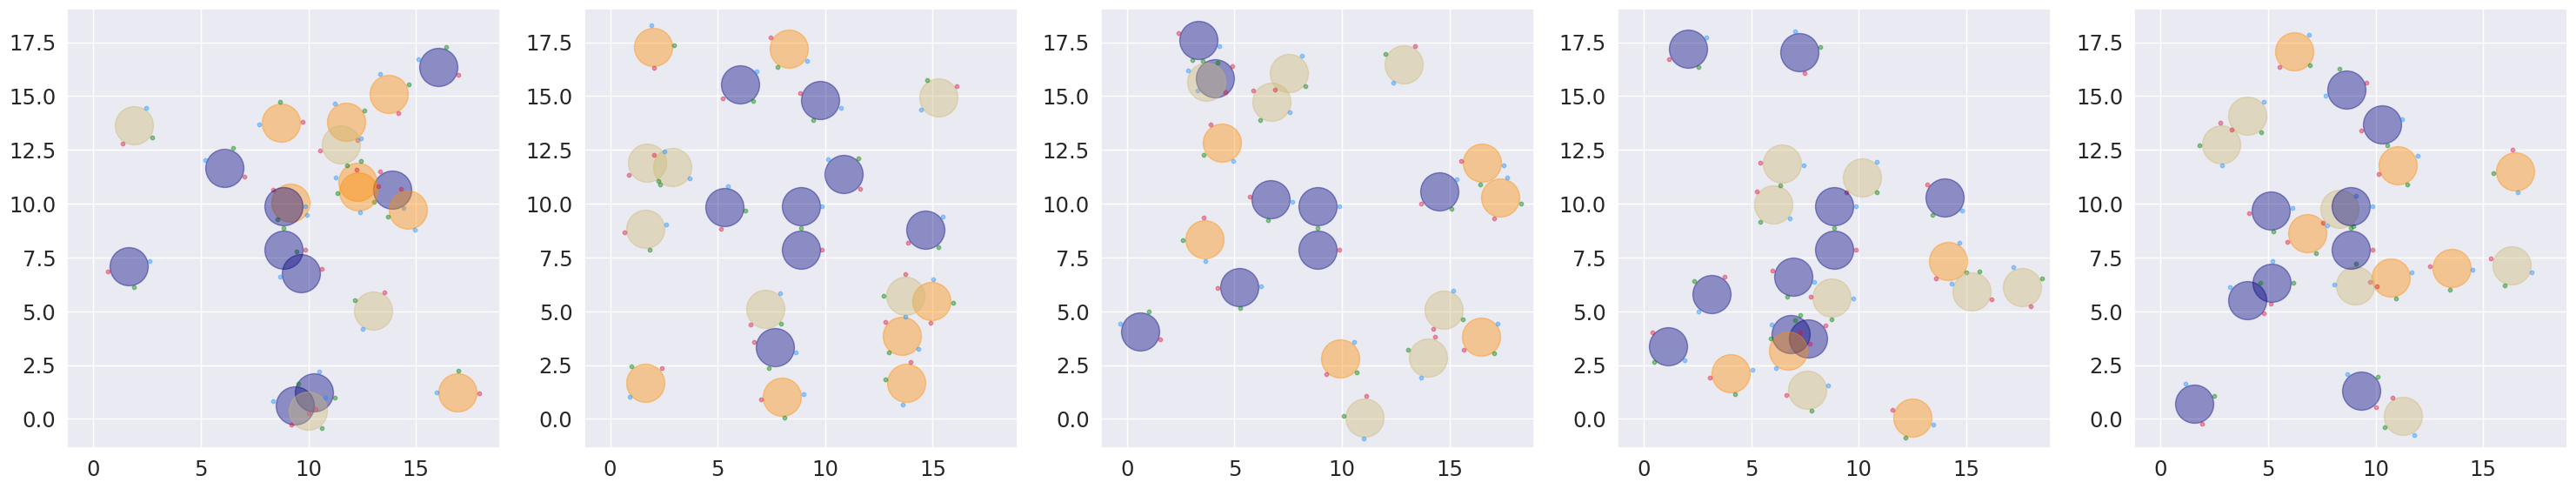

In [ ]:
key = random.PRNGKey(0)
key, split = random.split(key)
init_poss = v_gen_init_pos(N, box_size, random.split(split, ensemble_size))
# Randomly initialize the species
species = random.randint(key, (ensemble_size, N), minval = 1, maxval = 4, dtype = int)
# Set the first particle to be the seed (species 0)
species = species.at[:,0].set(0)

for j in range(ensemble_size):
  plt.subplot(1, 5, j +1)
  body_to_plot3(rigid_body.RigidBody(init_poss.center[j,:,:], init_poss.orientation[j,:]), thetas, box_size, species = species[j,:], markersize = 1000, markerratio = 0.01)

finalize_plot((5*0.8, 1*0.8))

# GNN update rule

In this section, we construct the GNN as the update rule for the first stage proofreading scheme. The architecture and code is adapted from jax_md.nn (https://github.com/jax-md/jax-md/blob/main/jax_md/nn.py).

The GNN consists of an encoder, a processor and a decoder.

Encoder encodes all the information of a particle into the node and edge embedding of the graph. The node embedding is set to be the species of the particle. For the edge embedding, we consider the pairwise distances of the central body and patches between the connected particles (i.e. neighbors within a cutoff range).

Processor aggregates the local information for each particle from its neighbors and update its edge and node embeddings using multi-layer perceptrons (MLP).

Decoder decodes the information associating with the node of a particle using a decoder, which outputs the probability of state change of the corresponding particle.

In [ ]:
########## GNN hyperparameters ###########
n_rec = 1 # Number of apply the processor module. Set to be 1, we just aggregate and update local information once
n_hidden = 5 # Number of hidden neurons
edge_threshold = 3.0 # The edge threshold for deciding which particles are connected)
sigmoid_bias = 8.0 # Additional bias for the last layer of the sigmoid activation = 8.0

First construct the graph.

In [ ]:
@jit # use JIT compilation to speed up the simulation, is one kind of decorator
def construct_graph(state, species, box_size, edge_threshold):
  '''
  Returns graph representing the structure of the particles

  Each particle is represented by a node in the graph. The particle type is
  stored as a node feature
  Two particles at a distance less than the threshold are connected by an edge
  The relative distance vector is stored as an edge feature, together with the
  orientation difference

  Args:
    state: particle state RigidBody(pos: [n_particles, 2], orientation: [n_particles, ])
    species: particle types with shape [n_particles]
    box_size: float
    edge_threshold: float
  '''

  pos = state.center
  orientations = state.orientation

  # Calculate pairwise relative distances between central particles: shape [n, n, 2]
  displacement_fn, _ = space.periodic(box_size)
  vdisp = space.map_product(displacement_fn)

  seed_pos = transform(state[0], thetas_to_shape_seed(jnp.pi*0.5, center_particle_rad))
  ds = space.distance(vdisp(pos, pos))

  # Calculate pairwise relative distances between patches
  body = rigid_body.RigidBody(pos[1:,:], orientations[1:])
  all_pos = vmap(transform, (0, None))(body, thetas_to_shape(thetas, center_particle_rad))
  all_pos0 = jnp.moveaxis(all_pos, 0, 1)
  patch1_pos = jnp.concatenate((seed_pos[-1][None,:], all_pos0[1,:,:]))
  patch2_pos = jnp.concatenate((seed_pos[-2][None,:], all_pos0[2,:,:]))

  ds21 = space.distance(vdisp(patch2_pos, patch1_pos))
  ds12 = space.distance(vdisp(patch1_pos, patch2_pos))
  ds_patch = jnp.where(ds12 < ds21, ds12, ds21)

  #Define graph
  nodes = species[:, None]
  nodes = jnp.where(nodes == 1, 0, 1)
  nodes = nodes.at[0].set([2]) # the node of the seed is set to be 2
  mat = jnp.diag(jnp.ones(N))
  edges = jnp.concatenate((ds[:,:,jnp.newaxis], ds_patch[:,:,jnp.newaxis]), axis = -1)
  edge_idx = jnp.broadcast_to(jnp.arange(N)[jnp.newaxis, :], (N, N))
  edge_idx = jnp.where(ds < edge_threshold, edge_idx, N)
  edge_idx_new = jnp.where(mat == 1, N, edge_idx)
  return jax_md.nn.GraphsTuple(nodes.astype(onp.float64), edges.astype(onp.float64), None, edge_idx_new.astype(onp.int64))

Modify source code from jax_md.nn

In [ ]:
from functools import wraps, partial
from typing import Callable, Tuple, TextIO, Dict, Any, Optional
from jax_md import partition, nn

class EnergyGraphNet(hk.Module):
  """Implements a Graph Neural Network for state change update rule.
  This model uses a GraphNetEmbedding combined with a decoder applied to the
  node state.
  """
  def __init__(self,
               n_recurrences: int,
               n_hidden: int,
               mlp_kwargs: Optional[Dict[str, Any]]=None,
               format: partition.NeighborListFormat=partition.Dense,
               name: str='Energy'):
    super(EnergyGraphNet, self).__init__(name=name)

    if mlp_kwargs is None:
      mlp_kwargs = {
        'activation': jax.nn.leaky_relu,
        'w_init': hk.initializers.RandomUniform(minval=0.0, maxval=1.0)
      }
    self._format = format
    self._graph_net = GraphNetEncoder(n_recurrences,
                                         n_hidden,
                                         mlp_kwargs,
                                         format)
    self._decoder = hk.nets.MLP(output_sizes=(n_hidden, 1),
                                activate_final=False,
                                name='NodeDecoder',
                                **mlp_kwargs)

  def __call__(self, graph: nn.GraphsTuple) -> jnp.ndarray:
    output = self._graph_net(graph)
    output = jnp.squeeze(jax.nn.sigmoid(self._decoder(output.nodes) - sigmoid_bias), axis=-1)
    if self._format is partition.Sparse:
      output = output[0]
    return output


def _apply_node_fn(graph: nn.GraphsTuple,
                   node_fn: Callable[[Array,Array, Array, Array], Array]
                   ) -> Array:
  if graph.edges is not None:
    flat_edges = jnp.reshape(graph.edges, (-1, graph.edges.shape[-1]))
    edge_idx = jnp.reshape(graph.edge_idx, (-1,))
    incoming_edges = jax.ops.segment_sum(flat_edges, edge_idx, graph.nodes.shape[0] + 1)[:-1]
  else:
    raise ValueError()
  return node_fn(jnp.concatenate((graph.nodes, incoming_edges), axis = -1))


def _apply_edge_fn(graph: nn.GraphsTuple,
                   edge_fn: Callable[[Array, Array, Array, Array], Array]
                   ) -> Array:
  if graph.nodes is not None:
    incoming_nodes = graph.nodes[graph.edge_idx]
    outgoing_nodes = jnp.broadcast_to(
        graph.nodes[:, jnp.newaxis, :],
        graph.edge_idx.shape + graph.nodes.shape[-1:])
  else:
    raise ValueError()

  mask = graph.edge_idx < graph.nodes.shape[0]
  mask = mask[:, :, jnp.newaxis]
  return edge_fn(jnp.concatenate((graph.edges, incoming_nodes, outgoing_nodes), axis = -1)) * mask

from jax_md import dataclasses

class InteractionNetwork:
  """Implementation of a Graph Network.
  See https://arxiv.org/abs/1806.01261 for more details.
  """
  def __init__(self,
               edge_fn: Callable[[Array], Array],
               node_fn: Callable[[Array], Array],
               global_fn: Callable[[Array], Array]):
    self._node_fn = partial(_apply_node_fn, node_fn=vmap(node_fn))

    self._edge_fn = partial(_apply_edge_fn, edge_fn=vmap(vmap(edge_fn)))

    self._global_fn = None

  def __call__(self, graph: nn.GraphsTuple) -> nn.GraphsTuple:
    if self._edge_fn is not None:
      graph = dataclasses.replace(graph, edges = self._edge_fn(graph))
    else:
      raise ValueError()

    if self._node_fn is not None:
      graph = dataclasses.replace(graph, nodes=self._node_fn(graph))
    else:
      raise ValueError()

    return graph


'''
GNN in Every layer of n_rec use the same weights
'''
class GraphNetEncoder(hk.Module):
  """
  Based on the network used in "Unveiling the predictive power of static
  structure in glassy systems"; Bapst et al.
  (https://www.nature.com/articles/s41567-020-0842-8). This network first
  embeds edges, nodes, and global state. Then `n_recurrences` of GraphNetwork
  layers are applied. Unlike in Bapst et al. this network does not include a
  readout, which should be added separately depending on the application.

  """
  def __init__(self,
               n_recurrences: int,
               n_hidden: int,
               mlp_kwargs: Optional[Dict[str, Any]]=None,
               format: partition.NeighborListFormat=partition.Dense,
               name: str='GraphNetEncoder'):
    super(GraphNetEncoder, self).__init__(name=name)

    if mlp_kwargs is None:
      mlp_kwargs = {}

    self._n_recurrences = n_recurrences

  def __call__(self, graph: nn.GraphsTuple) -> nn.GraphsTuple:
    output_graph = graph

    model_fn = functools.partial(
          hk.nets.MLP,
          activation = jax.nn.leaky_relu,
          w_init = hk.initializers.RandomUniform(minval=0.0, maxval=1.0))

    update_edge_fn = model_fn(output_sizes=(n_hidden, 2), name = 'EdgeFunction', activate_final=True)
    update_node_fn = model_fn(output_sizes=(n_hidden, 1), name = 'NodeFunction', activate_final=True)
    gn = InteractionNetwork(update_edge_fn, update_node_fn, None)

    for i in range(self._n_recurrences):
      input_graph = output_graph
      output_graph = gn(input_graph)
    return output_graph

# Simulation - state change

In this section, we set up the simulation of the system with the first-stage proofreading mechanism, i.e. state change.

Specifically, we use the NVT_NOSE_HOOVER thermostat. The relevant parameters are defined in the Section *Set up the system*.

In [ ]:
from jax_tqdm import scan_tqdm

In [ ]:
################ Simulation #################
def run_simulation_1(key, num_steps, init_pos, init_species, params, net_apply, edge_threshold, strong_e, alpha_morse, weak_e = 4.0, kT = 1.0, alpha_soft = 2.0, r_cutoff = 1.0):
  '''
  Arguments:
    key: seed for generating random number
    num_steps: simulation steps
    init_pos: the initial state of the system, a rigid body object including both the position and orientation of each particle
    init_species: the initial species of the system. Usually the first one is set to be 0, which is the seed
    params: parameters of the GNN as the update rule
    net_apply: function for instantiating the GNN update rule
    edge_threshold: edge threshold for determining the connectivity between particles within the graph
    strong_e: the strong interaction energy after state change
    alpha_morse: interaction range for the Morse potential
    weak_e: the weak interaction energy before state change
    kT: temperature
    alpha_soft: interaction range for the soft sphere potential
    r_cutoff: a cutoff distance for the Morse potential
  Returns:
    state: the final state of the forward simulation
    species: the final species of the forward simulation
    energiess: energy trajectory during the simultion
    lnps: trajectory of the log(probability) during the simultion
  '''

  displacement_fn, shift_fn = space.periodic(box_size)

  # define the interaction matrix of patches within each species
  energy_patch0 = jnp.array([0.0, weak_e, 0.0, 0.0, 0.0, weak_e])
  energy_patch1 = jnp.array([0.0, strong_e, 0.0, 0.0, 0.0, strong_e])

  @jit
  def gen_morse_eps(energy_patch):
    ind_i, ind_j = jnp.triu_indices(num_patch)
    eng = jnp.zeros((num_patch, num_patch))
    eng = eng.at[ind_i, ind_j].set(energy_patch)
    eng_patch = eng.at[ind_j, ind_i].set(energy_patch)
    morse_eps_sub = jnp.pad(eng_patch, pad_width = (1, 0))
    return morse_eps_sub
  # define the whole interaction matrix of patches
  morse_eps = jnp.vstack((jnp.hstack((gen_morse_eps(energy_patch0), gen_morse_eps(energy_patch1))), jnp.hstack((gen_morse_eps(energy_patch1), gen_morse_eps(energy_patch1)))))
  pair_energy_morse = energy.morse_pair(displacement_fn, species = (1+num_patch)*2, sigma = 0.0, epsilon = morse_eps, alpha = alpha_morse, r_cutoff = r_cutoff)

  # centers interact via soft sphere potential
  soft_sphere_eps = jnp.zeros((1+num_patch, 1+num_patch))
  soft_sphere_eps = soft_sphere_eps.at[0, 0].set(max_energy_center)
  soft_sphere_eps = jnp.vstack((jnp.hstack((soft_sphere_eps, soft_sphere_eps)), jnp.hstack((soft_sphere_eps, soft_sphere_eps))))
  pair_energy_soft_sphere = energy.soft_sphere_pair(displacement_fn, species = (1+num_patch)*2, sigma = center_particle_rad*2, alpha = alpha_soft, epsilon = soft_sphere_eps)

  # total interaction potential
  pair_energy_fn = lambda R, **kwargs: pair_energy_morse(R, **kwargs) + pair_energy_soft_sphere(R, **kwargs)

  # adapt the energy function to allow dynamical species update
  @jit
  def E(R, shape, body_type, species=None, body_id=None, **kwargs):
    ind = (body_type[body_id].reshape((-1,num_patch+1))*(1+num_patch) + jnp.arange(1+num_patch)).reshape((1,-1))[0]
    species = (shape.point_species)[ind]
    return pair_energy_fn(R, species=species, **kwargs)

  # initial species: all particles start in weak interaction state, except for the seed
  species0 = onp.where(onp.arange(N) < 1,0,1)
  energy_fn = point_energy(E, shape, shape_species = species0)

  '''state change update rule'''
  @jit
  def update_species_prob(body, pre_species, key):
    # state change probability
    def state_change_prob(state, species):
      out_graph = construct_graph(state, species, box_size, edge_threshold)
      prob = net_apply(params, out_graph)
      return prob

    # sample from the probability
    species_1d = jnp.where(pre_species == 1, 1, 0)
    prob = state_change_prob(body, pre_species) * species_1d
    dists = Bernoulli(probs=prob)
    key, split = random.split(key)
    flips = dists.sample(seed=split)
    log_probs = dists.log_prob(flips)

    final_species = pre_species + flips
    return final_species.astype(int), jnp.sum(log_probs)

  init_fn, apply_fn = simulate.nvt_nose_hoover(energy_fn, shift_fn, dt, kT)
  key, split = random.split(key)
  state = init_fn(split, init_pos, mass=shape.mass(jnp.where(jnp.arange(N) < 1, 0, 1)), body_type = init_species)
  apply_fn = jit(apply_fn)

  '''Apply one-step simulation'''
  # @scan_tqdm(num_steps)
  @jit
  def do_step(state_zipped, t):
    state = state_zipped[0]
    pre_species = state_zipped[1]
    key = state_zipped[2]
    key, split = random.split(key)
    species, lnp = update_species_prob(state.position, pre_species, split)
    return [apply_fn(state, body_type = species), species, key], [energy_fn(state.position, body_type = species), lnp] # record the trajectory of total potential energy and log probability

  key, split = random.split(key)
  [state, species, _], [energiess, lnps] = lax.scan(do_step, [state, init_species, split], jnp.arange(num_steps))
  return state, species, energiess, lnps
run_simulation_1 = eqx.filter_jit(run_simulation_1, kwargs=dict(num_steps=False))
# vmap over the random keys in order to run multiple instances in parallel
v_sim_1 = eqx.filter_jit(eqx.filter_vmap(run_simulation_1, default=None, kwargs=dict(key=0,init_pos=0,init_species=0)), kwargs=dict(num_steps=False))

Here we show an example of the forward simulation using the final optimized parameters.

In [ ]:
Array = jnp.array
DeviceArray = jnp.array
float64 = jnp.float64

'''
Instantiate the GNN update rule
'''
_net = lambda g: EnergyGraphNet(n_rec, n_hidden)(g)
net = hk.without_apply_rng(hk.transform(_net))
net_apply = eqx.filter_jit(net.apply)

Import the final optimized parameters

In [ ]:
params = {'Energy/~/GraphNetEncoder/EdgeFunction/~/linear_0': {'b': Array([-1.18229541,  0.20513625, -0.69926069, -0.66810714,  0.21926444],      dtype=float64),
  'w': Array([[ 0.20535051,  0.55619052,  0.85229362,  0.45234885,  0.50385948],
         [ 0.44683522,  0.71110345, -0.24775001, -0.53428168,  0.0746428 ],
         [-0.6946458 ,  0.60775974, -0.68313352, -0.19648135,  0.52503446],
         [ 0.27281617,  0.62102602,  0.74422965,  0.89887198,  0.20466965]],      dtype=float64)},
 'Energy/~/GraphNetEncoder/EdgeFunction/~/linear_1': {'b': Array([ 0.50545273, -0.79070461], dtype=float64),
  'w': Array([[-2.23645675,  0.80871269],
         [-0.50541746, -0.2039328 ],
         [ 0.16701152,  0.99081466],
         [ 1.44868985,  0.8967157 ],
         [-0.07848047, -0.19936147]], dtype=float64)},
 'Energy/~/GraphNetEncoder/NodeFunction/~/linear_0': {'b': Array([ 0.5667586 , -0.75110278,  3.07078163,  0.9019175 ,  0.56755311],      dtype=float64),
  'w': Array([[-2.24289909e-03,  2.43864994e+00,  5.52439875e+00,
          -1.82616225e+00, -9.12716819e-01],
         [ 8.21427794e-01, -7.66010262e-01,  1.72995939e-01,
           1.99888669e-01,  8.58196787e-01],
         [ 4.77024718e-03,  1.40970996e+00, -1.85095708e+00,
           2.82242133e-01,  5.16288901e-02]], dtype=float64)},
 'Energy/~/GraphNetEncoder/NodeFunction/~/linear_1': {'b': Array([0.55382852], dtype=float64),
  'w': Array([[ 0.4413707 ],
         [-1.82085712],
         [-2.13144583],
         [ 0.67456537],
         [ 0.80520969]], dtype=float64)},
 'Energy/~/NodeDecoder/~/linear_0': {'b': Array([3.57217985, 1.21870433, 2.75032184, 2.40982965, 6.47181771],      dtype=float64),
  'w': Array([[-0.64499391, -0.9163762 , -0.42514341, -0.01285855, -2.26943022]],      dtype=float64)},
 'Energy/~/NodeDecoder/~/linear_1': {'b': Array([-0.01993288], dtype=float64),
  'w': Array([[ 1.84157834],
         [ 6.40763531],
         [ 1.25550201],
         [ 1.05686399],
         [-4.58751284]], dtype=float64)}}

Run the simulation

In [ ]:
# randomly generate initial condition
key, split = random.split(key)
init_poss = v_gen_init_pos(N, box_size, random.split(split, ensemble_size))
init_sps = jnp.repeat(onp.where(onp.arange(N) < 1,0,1)[jnp.newaxis,...], ensemble_size, axis=0)

# run the simulation. You can decrease the simulation steps (n_step) to reduce the computation time.
key, split = random.split(key)
state_after, species_after, energiess, _ = v_sim_1(random.split(split, ensemble_size), n_steps, init_poss, init_sps, params, net_apply, edge_threshold, strong_e, alpha_morse, weak_e, kT, alpha_soft, r_cutoff)

Let's plot and see what the final configurations are.

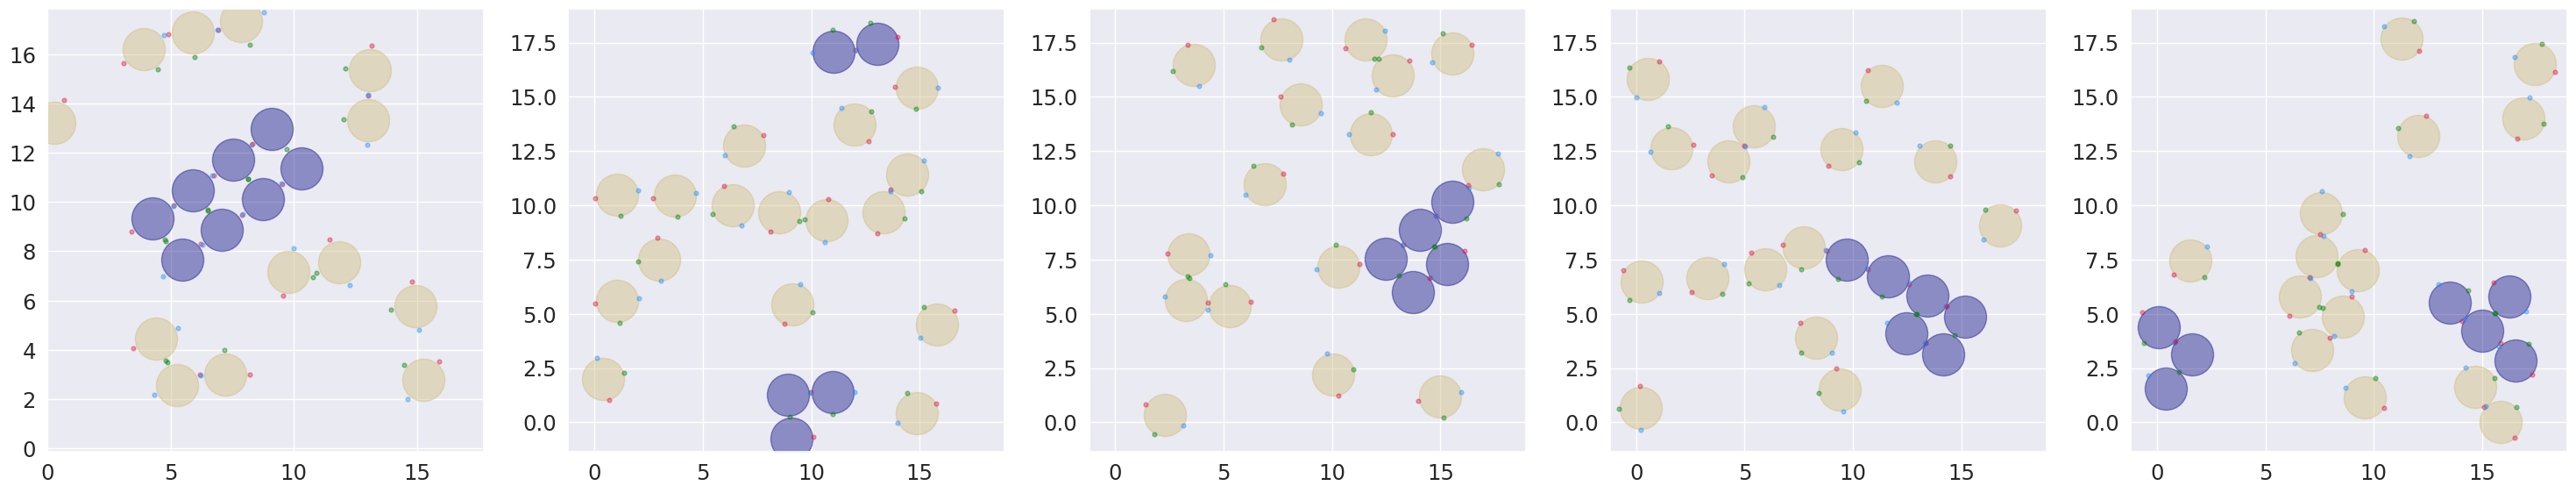

In [ ]:
for j in range(ensemble_size):
  plt.subplot(1, 5, j +1)
  body_to_plot3(state_after.position[j], thetas, box_size, species = species_after[j,:], markersize = 1200, markerratio = 0.01)

finalize_plot((5*0.8, 1*0.8))

Plot the energy trajectory.

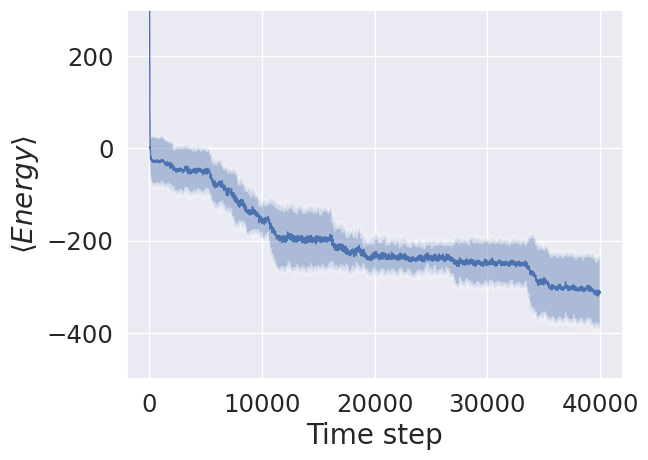

In [ ]:
plot_energy(energiess, n_steps, upper = 300, lower = -500)

# Optimize the GNN

In this section, we set up the optimization of GNN to learn the optimal state change rule that can give rise to robust growth of our desired structure. The specific parameters used in practice can be found in the main text and the accompanying SI. As a demo, here we only run 2 optimization steps and use a relatively small batch size.

In [ ]:
ensemble_size = 10
loop_batch = 1 # the total batch size for one optimization step = loop_batch x ensemble_size
n_steps = 5000
n_steps_opt = 1000 # back-propagate the loss through the last n_steps_opt steps
opt_steps = 2 # optimization steps
lr = 0.005 # learning rate

## Define loss function

To order to train the GNN, we need to first define the loss function. Detailed description can be found in the accompanying SI.

In [ ]:
def sys_loss(center, orient, species):
  # calculate the number of state changed particles and the length of the ideal structures of the same size
  l = jnp.sum(1-jnp.remainder(species,2))

  # the total potential energy of the ideal structure of the same size
  std_eng = -(((l-1)//2) * 3+jnp.remainder(l-1, 2))*strong_e

  # then calculate the total potential energy of the our simulated structure
  displacement_fn, _ = space.periodic(box_size)

  # we only consider the energy of structures consisted of state changed particles, i.e. species 2
  e0 = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
  e1 = jnp.array([0.0, strong_e, 0.0, 0.0, 0.0, strong_e])

  @jit
  def gen_morse_eps(energy_patch):
    ind_i, ind_j = jnp.triu_indices(num_patch)
    eng = jnp.zeros((num_patch, num_patch))
    eng = eng.at[ind_i, ind_j].set(energy_patch)
    eng_patch = eng.at[ind_j, ind_i].set(energy_patch)
    morse_eps_sub = jnp.pad(eng_patch, pad_width = (1, 0))
    return morse_eps_sub
  m_eps = jnp.vstack((jnp.hstack((gen_morse_eps(e0), gen_morse_eps(e0))), jnp.hstack((gen_morse_eps(e0), gen_morse_eps(e1)))))
  pair_m = energy.morse_pair(displacement_fn, species = (1+num_patch)*2, sigma = 0.0, epsilon = m_eps, alpha = alpha_morse, r_cutoff = r_cutoff)

  # centers interact via soft sphere potential
  ss_eps = jnp.zeros((1+num_patch, 1+num_patch))
  ss_eps = ss_eps.at[0, 0].set(max_energy_center) # define energy range
  ss_eps = jnp.vstack((jnp.hstack((ss_eps, ss_eps)), jnp.hstack((ss_eps, ss_eps))))
  pair_s = energy.soft_sphere_pair(displacement_fn, species = (1+num_patch)*2, sigma = center_particle_rad*2, alpha = alpha_soft, epsilon = ss_eps)

  pair_e_fn = lambda R, **kwargs: pair_m(R, **kwargs) + pair_s(R, **kwargs)

  @jit
  def _E(R, shape, body_type, species=None, body_id=None, **kwargs):
    ind = (body_type[body_id].reshape((-1,num_patch+1))*4 + jnp.arange(1+num_patch)).reshape((1,-1))[0]
    species = (shape.point_species)[ind]
    return pair_e_fn(R, species=species, **kwargs)

  # this gives the total potential energy of the structure consisted of state changed particles
  e_fn = point_energy(_E, shape, shape_species = onp.where(onp.arange(N) < 1,0,1))

  # Total loss = (energy difference)^2 - 6000 x max(Number of state changed particles, 5).
  return (e_fn(rigid_body.RigidBody(center, orient), body_type = species) - std_eng)**2 - jnp.clip(l-1, None, 5)*6000.

'''
Function to calculate the mean loss over a batch of simulations
'''
def avg_loss(R_batched, O_batched, S_batched):
  # R/O/S_batched refer to position/orientation/species respectively
  losses = vmap(sys_loss, (0,0,0))(R_batched, O_batched, S_batched)
  return losses

## Training

In [ ]:
'''
Function for running a batch of forward simulations and calculate the mean loss over the final configurations.
It also record the log probability associating with the trajectory.
It returns the gradient estimator, which is the REINFORCE gradient, and the actual loss function.
'''
def get_mean_loss(params, sim_keys, num_steps_opt, init_poss, init_speciess, net_apply):
  statess, speciess, _, lnpss = v_sim_1(sim_keys, num_steps_opt, init_poss, init_speciess, params, net_apply, edge_threshold, strong_e, alpha_morse, weak_e, kT, alpha_soft, r_cutoff)
  loss = avg_loss(statess.position.center, statess.position.orientation, speciess) # the actual loss
  gradient_estimator = loss + jnp.sum(lnpss, -1) * jax.lax.stop_gradient(loss) # the REINFORCE term
  return jnp.mean(gradient_estimator), jnp.mean(loss)
# Take gradients of the first term, i.e. the gradient estimator
get_mean_loss = eqx.filter_jit(value_and_jacfwd(eqx.filter_jit(get_mean_loss, kwargs=dict(num_steps_opt=False))), kwargs=dict(num_steps_opt=False))

In [ ]:
def optimization(input_params, opt_steps, key, net_apply, learning_rate = 0.1, resume = False):
  '''
  Training of the GNN
  Arguments:
    input_params: the initial GNN parameters to start the optimization
    opt_steps: optimization steps
    key: seed for generating random number
    net_apply: function for instantiating the GNN update rule
    learning_rate: learning rate for the Adam optimizer
    resume: a boolean determining whether or not to resume the optimization from some previous stage
  Returns:
    loss_array: the loss trajectory during the optimization process
    min_loss_params: the set of parameters corresponding to the lowest loss
  '''
  opt_init, opt_update, get_params = optimizers.adam(step_size = learning_rate)

  '''Place to store your results'''
  # loss_file = OPT_DIR_NAME + '/loss' + str(learning_rate) + '.txt'
  # grad_file = OPT_DIR_NAME + '/grad' + str(learning_rate) + '.txt'
  # param_file = OPT_DIR_NAME + '/params' + str(learning_rate) + '.txt'
  # Check if these files exist, if yes delete them
  # def clear_files(filenames):
  #   for fn in filenames:
  #     if exists(fn):
  #       os.remove(fn)
  # Whether or not to resume the optimization from some previous stage
  # if not resume:
  #   clear_files([loss_file, grad_file, param_file])

  opt_state = opt_init(input_params)
  init_sps = jnp.repeat(onp.where(onp.arange(N) < 1, 0, 1)[jnp.newaxis,...], ensemble_size, axis=0)

  '''One step of the optimization'''
  def step(i, opt_state, key):
    params = get_params(opt_state)
    loss = 0
    grad = jax.tree_util.tree_map(lambda x: 0.0, params)
    for j in range(loop_batch):
      key, pos_key, split = random.split(key, 3)
      key_batches = random.split(split, ensemble_size)
      init_positions = v_gen_init_pos(N, box_size, random.split(pos_key, ensemble_size))
      # first run n_steps forward simulation
      state_after, species_after, _, _ = v_sim_1(key_batches, n_steps, init_positions, init_sps, params, net_apply, edge_threshold, strong_e, alpha_morse, weak_e, kT, alpha_soft, r_cutoff)
      final_positions = state_after.position
      key, split = random.split(key)
      # then back-propogate the loss through an additional n_steps_opt simulation following that
      _, l, g = get_mean_loss(params, random.split(split, ensemble_size), n_steps_opt, final_positions, species_after, net_apply)
      loss += l
      # clip the gradient in case of exploding gradients
      g_clipped = jax.tree_util.tree_map(lambda gs: jnp.clip(gs, -10000.0, 10000.0), g)
      grad = jax.tree_util.tree_map(lambda g_mean, g_single: g_mean + g_single/loop_batch, grad, g_clipped)
    loss = loss/loop_batch
    opt_state = opt_update(i, grad, opt_state)

    '''Store the results'''
    # with open(loss_file, 'a') as out1:
    #   out1.write("{}".format(loss)+'\n')

    # with open(grad_file, 'a') as out2:
    #   value, _ = jax.tree_util.tree_flatten(grad)
    #   temp_grad = [item.reshape(-1,1).tolist()[0][0] for sublist in value for item in sublist.flatten()]
    #   separator = ', '
    #   out2.write(separator.join(['{}'.format(temp) for temp in temp_grad]) + '\n')

    # with open(param_file, 'a') as out3:
    #   value, _ = jax.tree_util.tree_flatten(params)
    #   temp_param = [item.reshape(-1,1).tolist()[0][0] for sublist in value for item in sublist.flatten()]
    #   separator = ', '
    #   out3.write(separator.join(['{}'.format(temp) for temp in temp_param]) + '\n')

    return opt_state, [loss, grad]

  min_loss_params = input_params
  min_loss = 1e6

  print(f"I'll start optimization iteration now! The learning rate is {learning_rate}.")

  loss_array = jnp.ones(opt_steps)

  for i in range(opt_steps):
    key, split = random.split(key)
    start = time.time()
    new_opt_state, [loss, grad] = step(i, opt_state, split)
    end = time.time()
    loss_array = loss_array.at[i].set(loss)
    print(f"@Opt step {i}")
    if loss < min_loss:
      min_loss = loss
      min_loss_params = get_params(opt_state)
    print(f"This step takes {end - start} seconds")
    print(f"the loss is {loss}, the gradients are {grad}, and the params is {get_params(opt_state)}\n")
    opt_state = new_opt_state

  return loss_array, min_loss_params


As described in the main text and SI, the optimization process start with a pretraining procedure. Here we directly provide the pretrained parameters.

In [ ]:
# Pretrained parameters as a starting point for the optimization
init_params = {'Energy/~/GraphNetEncoder/EdgeFunction/~/linear_0': {'b': DeviceArray([-1.13418249,  0.149055  , -0.75586254, -0.66748934,
              0.20899104], dtype=float64), 'w': DeviceArray([[ 0.27337813,  0.54538112,  0.8383323 ,  0.41698345,
               0.54232235],
             [ 0.3707864 ,  0.58933672, -0.26319253, -0.45535186,
               0.07077622],
             [-0.6946458 ,  0.60775974, -0.68313352, -0.19648135,
               0.52503446],
             [ 0.34718856,  0.57346451,  0.71154209,  0.82476851,
               0.22687433]], dtype=float64)}, 'Energy/~/GraphNetEncoder/EdgeFunction/~/linear_1': {'b': DeviceArray([ 0.58116179, -0.84939296], dtype=float64), 'w': DeviceArray([[-2.13961184,  0.77773612],
             [-0.56130869, -0.18391193],
             [ 0.13671205,  0.99170512],
             [ 1.45530629,  0.88292526],
             [-0.08186159, -0.21568271]], dtype=float64)}, 'Energy/~/GraphNetEncoder/NodeFunction/~/linear_0': {'b': DeviceArray([ 0.62613904, -0.81080883,  3.05066523,  0.98229421,
              0.64961796], dtype=float64), 'w': DeviceArray([[-2.24289909e-03,  2.43864994e+00,  5.52439875e+00,
              -1.82616225e+00, -9.12716819e-01],
             [ 8.71239265e-01, -8.05153109e-01,  1.95419999e-01,
               2.59156301e-01,  9.18118050e-01],
             [ 6.26164246e-02,  1.37934562e+00, -1.86778140e+00,
               3.66274983e-01,  1.41134328e-01]], dtype=float64)}, 'Energy/~/GraphNetEncoder/NodeFunction/~/linear_1': {'b': DeviceArray([0.63380787], dtype=float64), 'w': DeviceArray([[ 0.52137547],
             [-1.80141873],
             [-2.07949102],
             [ 0.76731621],
             [ 0.88406659]], dtype=float64)}, 'Energy/~/NodeDecoder/~/linear_0': {'b': DeviceArray([3.68397424, 1.35614379, 2.86249328, 2.52094937, 6.3403174 ],            dtype=float64), 'w': DeviceArray([[-0.55479078, -0.87781969, -0.33059782,  0.07768757,
              -2.35091474]], dtype=float64)}, 'Energy/~/NodeDecoder/~/linear_1': {'b': DeviceArray([0.09367993], dtype=float64), 'w': DeviceArray([[ 1.95486159],
             [ 6.54305398],
             [ 1.36698245],
             [ 1.17129269],
             [-4.46873703]], dtype=float64)}}

Start the optimization

In [23]:
key = random.PRNGKey(42)
key, split = random.split(key)
# Again you can decrease the simulation steps (n_step), batch size (ensemble_size, loop_batch) to reduce the computation time.
# Although note that smaller batch size and shorter simulation may lead to degradation in the training
loss_arr, min_loss_params = optimization(init_params, opt_steps, split, net_apply, learning_rate = lr, resume = False)

I'll start optimization iteration now! The learning rate is 0.005.
@Opt step 0
This step takes 40.63198947906494 seconds
the loss is -3263.9416965633463, the gradients are {'Energy/~/GraphNetEncoder/EdgeFunction/~/linear_0': {'b': Array([10000.        ,  4898.39956634,  6174.87103348, -9540.5169287 ,
        -755.1417309 ], dtype=float64), 'w': Array([[ 10000.        ,  10000.        ,  10000.        ,
        -10000.        ,  -1866.5241327 ],
       [  4715.04087399,    763.12380746,    970.51886856,
         -1483.24825561,   -119.34576387],
       [     0.        ,      0.        ,      0.        ,
             0.        ,      0.        ],
       [ 10000.        ,   9799.1431788 ,  10000.        ,
        -10000.        ,  -1509.28755117]], dtype=float64)}, 'Energy/~/GraphNetEncoder/EdgeFunction/~/linear_1': {'b': Array([-10000.        ,   7781.00347775], dtype=float64), 'w': Array([[ -3313.14330339,   2287.36994787],
       [-10000.        ,  10000.        ],
       [-10000.     

# Simulation - Reverse Pathway

In this section, we add the reverse pathway as the second stage of our proofreading scheme. Detailed description can be found in the main text.

In [ ]:
'''Parameters for the second stage'''
k2 = 0.00002 # the probability of a species 2 (purple) particle to transition into species 3 (orange) particle
k3 = 0.0002 # the probability of a species 3 (orange) particle to transition into species 1 (yellow) particle

In [ ]:
################ Simulation #################
def run_simulation_2(key, num_steps, init_pos, init_species, params, net_apply, edge_threshold, strong_e, alpha_morse, weak_e = 4.0, kT = 1.0, alpha_soft = 2.0, r_cutoff = 1.0):
  '''
  Arguments:
    key: seed for generating random number
    num_steps: simulation steps
    init_pos: the initial state of the system, a rigid body object including both the position and orientation of each particle
    init_species: the initial species of the system. Usually the first one is set to be 0, which is the seed
    params: parameters of the GNN as the update rule
    net_apply: function for instantiating the GNN update rule
    edge_threshold: edge threshold for determining the connectivity between particles within the graph
    strong_e: the strong interaction energy after state change
    alpha_morse: interaction range for the Morse potential
    weak_e: the weak interaction energy before state change
    kT: temperature
    alpha_soft: interaction range for the soft sphere potential
    r_cutoff: a cutoff distance for the Morse potential
  Returns:
    state: the final state of the forward simulation
    species: the final species of the forward simulation
    poss: trajectory of each particle's position & orientation during the simulation
    spss: trajectory of each particle's species during the simulation
  '''

  displacement_fn, shift_fn = space.periodic(box_size)

  # define the interaction matrix of patches within each species
  energy_patch0 = jnp.array([0.0, weak_e, 0.0, 0.0, 0.0, weak_e])
  energy_patch1 = jnp.array([0.0, strong_e, 0.0, 0.0, 0.0, strong_e])
  energy_patch2 = jnp.array([0.0, med_e, 0.0, 0.0, 0.0, med_e])

  @jit
  def gen_morse_eps(energy_patch):
    ind_i, ind_j = jnp.triu_indices(num_patch)
    eng = jnp.zeros((num_patch, num_patch))
    eng = eng.at[ind_i, ind_j].set(energy_patch)
    eng_patch = eng.at[ind_j, ind_i].set(energy_patch)
    morse_eps_sub = jnp.pad(eng_patch, pad_width = (1, 0))
    return morse_eps_sub
  # define the whole interaction matrix of patches
  morse_eps = jnp.vstack((jnp.hstack((gen_morse_eps(energy_patch0), gen_morse_eps(energy_patch1), gen_morse_eps(energy_patch0))), jnp.hstack((gen_morse_eps(energy_patch1), gen_morse_eps(energy_patch1), gen_morse_eps(energy_patch2))), jnp.hstack((gen_morse_eps(energy_patch0), gen_morse_eps(energy_patch2), gen_morse_eps(energy_patch0)))))
  pair_energy_morse = energy.morse_pair(displacement_fn, species = (1+num_patch)*3, sigma = 0.0, epsilon = morse_eps, alpha = alpha_morse, r_cutoff = r_cutoff)

  # centers interact via soft sphere potential
  soft_sphere_eps = jnp.zeros((1+num_patch, 1+num_patch))
  soft_sphere_eps = soft_sphere_eps.at[0, 0].set(max_energy_center)
  soft_sphere_eps = jnp.vstack((jnp.hstack((soft_sphere_eps, soft_sphere_eps, soft_sphere_eps)), jnp.hstack((soft_sphere_eps, soft_sphere_eps, soft_sphere_eps)), jnp.hstack((soft_sphere_eps, soft_sphere_eps, soft_sphere_eps))))
  pair_energy_soft_sphere = energy.soft_sphere_pair(displacement_fn, species = (1+num_patch)*3, sigma = center_particle_rad*2, alpha = alpha_soft, epsilon = soft_sphere_eps)

  # total interaction potential
  pair_energy_fn = lambda R, **kwargs: pair_energy_morse(R, **kwargs) + pair_energy_soft_sphere(R, **kwargs)

  # adapt the energy function to allow dynamical species update
  @jit
  def E(R, shape, body_type, species=None, body_id=None, **kwargs):
    ind = (body_type[body_id].reshape((-1,num_patch+1))*(1+num_patch) + jnp.arange(1+num_patch)).reshape((1,-1))[0]
    species = (shape.point_species)[ind]
    return pair_energy_fn(R, species=species, **kwargs)

  # initial species: all particles start in weak interaction state, except for the seed
  species0 = onp.where(onp.arange(N) < 1,0,1)
  energy_fn = point_energy(E, shape, shape_species = species0)

  '''state change update rule'''
  @jit
  def update_species_prob(body, pre_species, key):
    # state change probability
    def state_change_prob(state, species):
      # When constructing the GNN for state change, treat species 3 particle as the same as species 2
      species_p = jnp.where(species == 3, 1, species)
      out_graph = construct_graph(state, species_p, box_size, edge_threshold)
      prob = net_apply(params, out_graph)
      return prob

    # sample from the probability
    species_1d = jnp.where(pre_species == 1, 1, 0)
    prob = state_change_prob(body, pre_species) * species_1d
    dists = Bernoulli(probs=prob)
    key, split = random.split(key)
    flips = dists.sample(seed=split)
    log_probs = dists.log_prob(flips)

    # A transition rate for species 2 particle into species 3
    prob_2 = jnp.where(pre_species == 2, k2, 0)
    dists_2 = Bernoulli(probs=prob_2)
    key, split = random.split(key)
    flips_2 = dists_2.sample(seed=split)
    log_probs_2 = dists_2.log_prob(flips_2)

    # A transition rate for species 3 particle into species 1
    prob_3 = jnp.where(pre_species == 3, k3, 0)
    dists_3 = Bernoulli(probs=prob_3)
    key, split = random.split(key)
    flips_3 = dists_3.sample(seed=split)
    log_probs_3 = dists_3.log_prob(flips_3)

    final_species = pre_species + flips + flips_2 - 2*flips_3

    return final_species.astype(int), jnp.sum(log_probs) + jnp.sum(log_probs_2) + jnp.sum(log_probs_3)

  init_fn, apply_fn = simulate.nvt_nose_hoover(energy_fn, shift_fn, dt, kT)
  key, split = random.split(key)
  state = init_fn(split, init_pos, mass=shape.mass(jnp.where(jnp.arange(N) < 1, 0, 1)), body_type = init_species)
  apply_fn = jit(apply_fn)

  # @scan_tqdm(num_steps)
  @jit
  def do_step(state_zipped, t):
    state = state_zipped[0]
    pre_species = state_zipped[1]
    key = state_zipped[2]
    key, split = random.split(key)
    species, _ = update_species_prob(state.position, pre_species, split)
    return [apply_fn(state, body_type = species), species, key], [state.position, species] # record the trajectory of position and species

  key, split = random.split(key)
  [state, species, _], [poss, spss] = lax.scan(do_step, [state, init_species, split], jnp.arange(num_steps))
  return state, species, poss, spss
run_simulation_2 = eqx.filter_jit(run_simulation_2, kwargs=dict(num_steps=False))
# vmap over the random keys in order to run multiple instances in parallel
v_sim_2 = eqx.filter_jit(eqx.filter_vmap(run_simulation_2, default=None, kwargs=dict(key=0,init_pos=0,init_species=0)), kwargs=dict(num_steps=False))

This function can be used similarly as the demo in Section *Simulation - state change*

# Yield Definition

Here we attach the specific implementation of the yield function as defined in the SI.

In [ ]:
# the threshold values in defining the yield
c1 = 0.22
c2 = 0.35
c3 = 0.2

In [ ]:
def cal_yield(state_pos, state_ori):
  '''
  Function to calculate the yield
  Arguments:
    state_pos: position of all the particles in the system
    state_ori: orientation of all the particles in the system
  Returns:
    final_yield: the yield of the configuration (either 0 or 1)
  '''
  # distance matrix
  displacement_fn, _ = space.periodic(box_size)
  vdisp = space.map_product(displacement_fn)
  state = rigid_body.RigidBody(state_pos, state_ori)
  seed_pos = transform(state[0], thetas_to_shape_seed(jnp.pi*0.5, center_particle_rad))
  body0 = rigid_body.RigidBody(state.center[1:], state.orientation[1:])
  all_pos = vmap(transform, (0, None))(body0, thetas_to_shape(thetas, center_particle_rad))
  all_pos0 = jnp.moveaxis(all_pos, 0, 1)
  patch1_pos = jnp.concatenate((seed_pos[-1][None,:], all_pos0[1,:,:]))
  patch2_pos = jnp.concatenate((seed_pos[-2][None,:], all_pos0[2,:,:]))
  center_pos = jnp.concatenate((seed_pos[:2], all_pos0[0,:,:]))
  ds21 = space.distance(vdisp(patch2_pos, patch1_pos))
  ds12 = space.distance(vdisp(patch1_pos, patch2_pos))
  # compare the distance difference of these neighbors to perfect diagonal particle
  ds00 = abs(space.distance(vdisp(center_pos, center_pos))-2*jnp.sqrt(2)*center_particle_rad) # 2\sqrt(2)r represent the perfect diagonal neighbor
  ds0 = ds00[1:,1:]
  ds0 = ds0.at[:,0].set(jnp.where(ds00[1:,0]<ds00[1:,1], ds00[1:,0],ds00[1:,1]))
  # distance matrix between patch 1/2
  ds_patch = jnp.where(ds21 < ds12, ds21, ds12)
  dspatch_min = jnp.min(ds_patch, axis = -1)

  # distance matrix between patch 3
  patch3_pos = all_pos0[3,:,:]
  ds33 = space.distance(vdisp(patch3_pos, patch3_pos))
  patch3_dis = jnp.min(ds33 + jnp.diag(jnp.ones(N-1)*10000.), axis = -1)

  # orientation matrix
  map_ori = vmap(vmap(lambda x,y:x-y, (0, None), 0), (None, 0), 0)
  ori_dis = jnp.mod(map_ori(state_ori, state_ori), jnp.pi*2)
  ori_dis00 = abs(ori_dis - jnp.pi)
  ori_dis0 = ori_dis00[1:]
  # compare the orientation difference of these neighbors to perfect diagonal particle
  ori_dis0 = ori_dis0.at[:,0].set(jnp.mod(abs(ori_dis[1:,0] - jnp.pi*0.5), jnp.pi))

  # check for case IV, i.e. perfect ladder structure
  metric10 = jnp.where((ds0[1:] < c1) & (ori_dis0 < c2), 1, 0) # check for the perfect diagonal neighbor
  metric1 = jnp.clip((dspatch_min < c3)[1:] * jnp.sum(metric10, axis = -1), None, 1) # also check if patch is in direct contact with the others

  # check the special case III of compact ladder structure unequal arms
  metric2 = jnp.where(jnp.sum(jnp.where(ds_patch[1:, :] < c3, 1.0, 0.0), axis = -1) == 1, 1.0, 0.0) * jnp.where(patch3_dis > 1.0, 1.0, 0.0)

  # final metric: if it is case 1, then good, else check if it is case 2
  final_metric = jnp.where(metric1 == 1, 1, metric2)

  # check if every particle satisfies case IV or III.
  # As long as one particle does not satisfy either of these two cases,
  # the whole instance is counted as an incorrect structure with zero yield.
  final_yield = (1 - jnp.clip(jnp.sum(1-final_metric), None, 1))*(dspatch_min[0]<0.2)
  return final_yield